### Decomposing measures using PCA and t-sne

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none" # use all for maximum output

from Wind.Results import DBResults, DBMeasures
from Wind.Util.Maps import create_mapbox_plot
from Wind.Private.DBConfig import mapbox_token
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import seaborn as sns
from Wind.Private.DBConfig import mongolocaltest, mongolocal, mongolocalmeasures
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import pearsonr, kendalltau,spearmanr, normaltest
import scipy.stats as stats

from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as skl

import sklearn
print(sklearn.__version__)

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\merge.py:10: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



0.22.1


In [3]:
def create_lat_lon(sites):
   list_sites = sites['site'].tolist()
   latlon_df = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/20190823Summary_file.csv')
   df = latlon_df.loc[latlon_df['site_number'].isin(list_sites)]
   return df

In [4]:
query={'experiment':'JM_CNN_sep_2l_FULL', 'status':'done'}
# JM_RF_s2s_2, MLP_s2s_2
results = DBResults(conn=mongolocal)
results.retrieve_results(query)

results.sample(1.0)
a=results.extract_result(dset='test')

measure = DBMeasures(conn=mongolocalmeasures)
measure.retrieve_measures()
a = a[a[:,0].argsort()] # we sort by first column

df_states = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/site-state/20191225SummaryFile(0.6)-arreglado.csv')

### We create df_data as master dataframe with all the measures

In [5]:
b1=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend12h')
b2=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SampEnt')
b3=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
b4=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend1m')
b5=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season24h')
b6=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season1m')
b7=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SpecEnt')
b8=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Stab1w')
b9=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Lump1w')
df_data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'Trend12h_wind_speed':b1[:,1], 
                     'Trend24h_wind_speed':b3[:,1], 'Trend1m_wind_speed':b4[:,1],
                     'Season24h_wind_speed':b5[:,1], 'Season1m_wind_speed':b6[:,1], 'Season12h_wind_speed':b7[:,1],
                     'SampEnt_wind_speed':b2[:,1], 'SpecEnt_wind_speed':b7[:,1],
                     'Stab1w_wind_speed':b8[:,1], 'Lump1w_wind_speed':b9[:,1], 'state': df_states['state']})
df_data = df_data.dropna() # hay algun null por ahi limpiamos las filas erroneas

In [6]:
#data_sampled = data.sample(n=50000)
data_sampled = df_data
Y = data_sampled['CNN_sep_2L']
X = data_sampled[['Trend24h_wind_speed','Season24h_wind_speed', 
                  'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                  'Lump1w_wind_speed', 'Trend12h_wind_speed','Season12h_wind_speed'
                  ]]


In [7]:
df_forPCA = df_data.drop(['state','test'], axis=1)
print(df_forPCA.columns)

Index(['CNN_sep_2L', 'Trend12h_wind_speed', 'Trend24h_wind_speed',
       'Trend1m_wind_speed', 'Season24h_wind_speed', 'Season1m_wind_speed',
       'Season12h_wind_speed', 'SampEnt_wind_speed', 'SpecEnt_wind_speed',
       'Stab1w_wind_speed', 'Lump1w_wind_speed'],
      dtype='object')


In [8]:
from sklearn.decomposition import PCA

pca = PCA(3)  # project from 12 to 2 dimensions
projected = pca.fit_transform(df_forPCA)
print(df_forPCA.shape)
print(projected.shape)

(126661, 11)
(126661, 3)


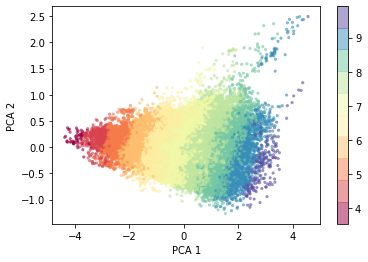

In [9]:
plt.scatter(projected[:, 0], projected[:, 2], c=df_forPCA.CNN_sep_2L, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar();



<Figure size 1296x1296 with 0 Axes>

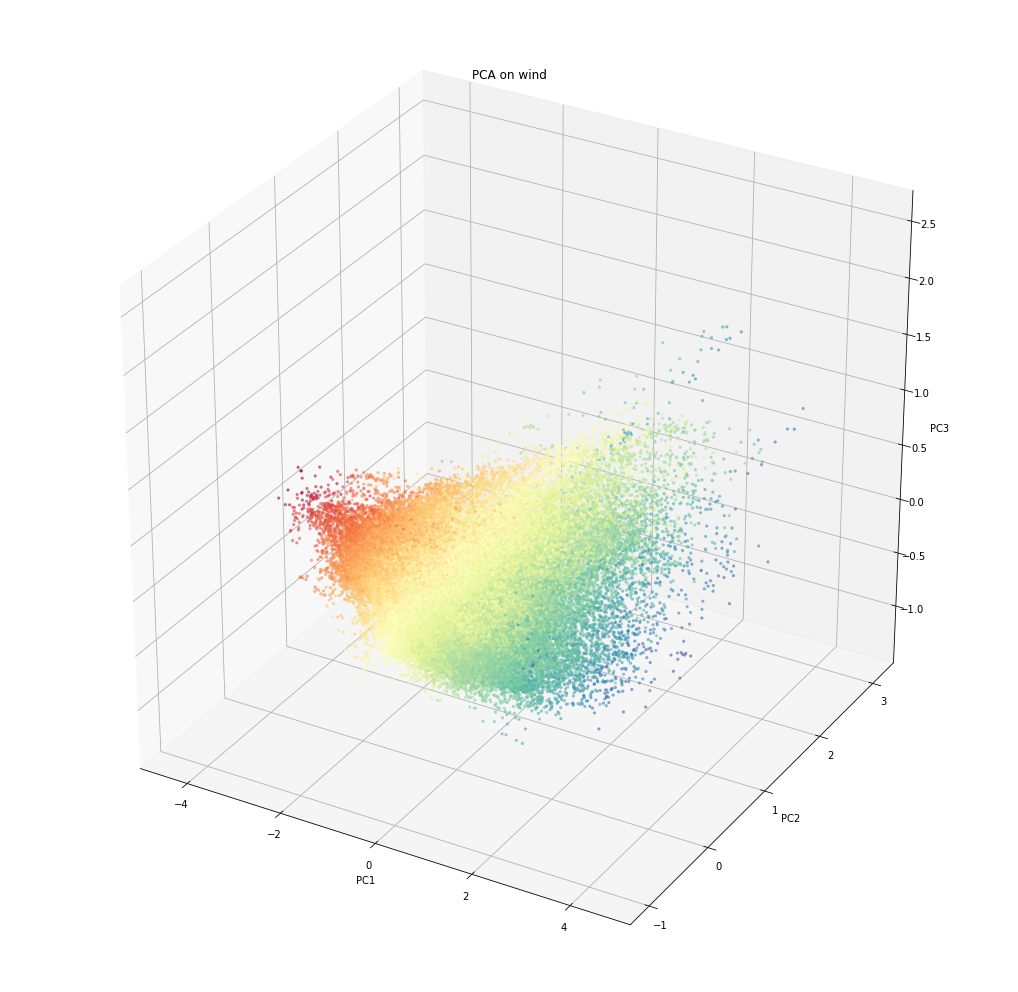

In [10]:
plt.figure(figsize=(18,18))
pca.fit(df_forPCA)
result=pd.DataFrame(pca.transform(df_forPCA), columns=['PCA%i' % i for i in range(3)], index=df_forPCA.index)

# Plot initialisation
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=df_forPCA.CNN_sep_2L, s=5, 
           cmap=plt.cm.get_cmap('Spectral'), alpha=0.5)


#ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=df_forPCA.CNN_sep_2L, s= 5,
#             edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10)) 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on wind")
#plt.show()


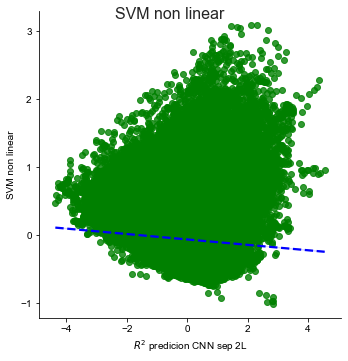

In [11]:
df_a = pd.DataFrame({'a': projected[:, 0], 'b': projected[:, 1]})

snsplot = sns.lmplot(x='a', y= 'b', palette= sns.color_palette("Reds"), data=df_a,
                     robust=True, scatter_kws={"color": "green"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','SVM non linear')
sns.set(font_scale=1.2)
sns.set_style(style='white')
fig = snsplot.fig 
fig.suptitle("SVM non linear ", fontsize=16)
snsplot.savefig('e:/figures/pollo.png', dpi=300)

In [12]:
from sklearn.manifold import TSNE
#https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [13]:
tsne_em = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(df_forPCA)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 126661 samples in 0.520s...
[t-SNE] Computed neighbors for 126661 samples in 12.071s...
[t-SNE] Computed conditional probabilities for sample 1000 / 126661
[t-SNE] Computed conditional probabilities for sample 2000 / 126661
[t-SNE] Computed conditional probabilities for sample 3000 / 126661
[t-SNE] Computed conditional probabilities for sample 4000 / 126661
[t-SNE] Computed conditional probabilities for sample 5000 / 126661
[t-SNE] Computed conditional probabilities for sample 6000 / 126661
[t-SNE] Computed conditional probabilities for sample 7000 / 126661
[t-SNE] Computed conditional probabilities for sample 8000 / 126661
[t-SNE] Computed conditional probabilities for sample 9000 / 126661
[t-SNE] Computed conditional probabilities for sample 10000 / 126661
[t-SNE] Computed conditional probabilities for sample 11000 / 126661
[t-SNE] Computed conditional probabilities for sample 12000 / 126661
[t-SNE] Computed conditional probab

[t-SNE] Computed conditional probabilities for sample 124000 / 126661
[t-SNE] Computed conditional probabilities for sample 125000 / 126661
[t-SNE] Computed conditional probabilities for sample 126000 / 126661
[t-SNE] Computed conditional probabilities for sample 126661 / 126661
[t-SNE] Mean sigma: 0.031257
[t-SNE] KL divergence after 250 iterations with early exaggeration: 103.059830
[t-SNE] KL divergence after 1000 iterations: 3.169553


In [25]:
from matplotlib.colors import DivergingNorm

df_forPCA['tsne-2d-one'] = tsne_em[:,0]
df_forPCA['tsne-2d-two'] = tsne_em[:,1]

df_forPCA.sample(10000)

In [31]:
# ejemplo with 100 para ver como sale el scatterplot
df1 = df_forPCA.sample(100)
print(df1.shape)

norm = DivergingNorm(vmin=df1.CNN_sep_2L.min(), vcenter=6.5, vmax=df1.CNN_sep_2L.max())
colors = [plt.cm.RdYlGn(norm(c)) for c in df1['CNN_sep_2L']]


(100, 13)


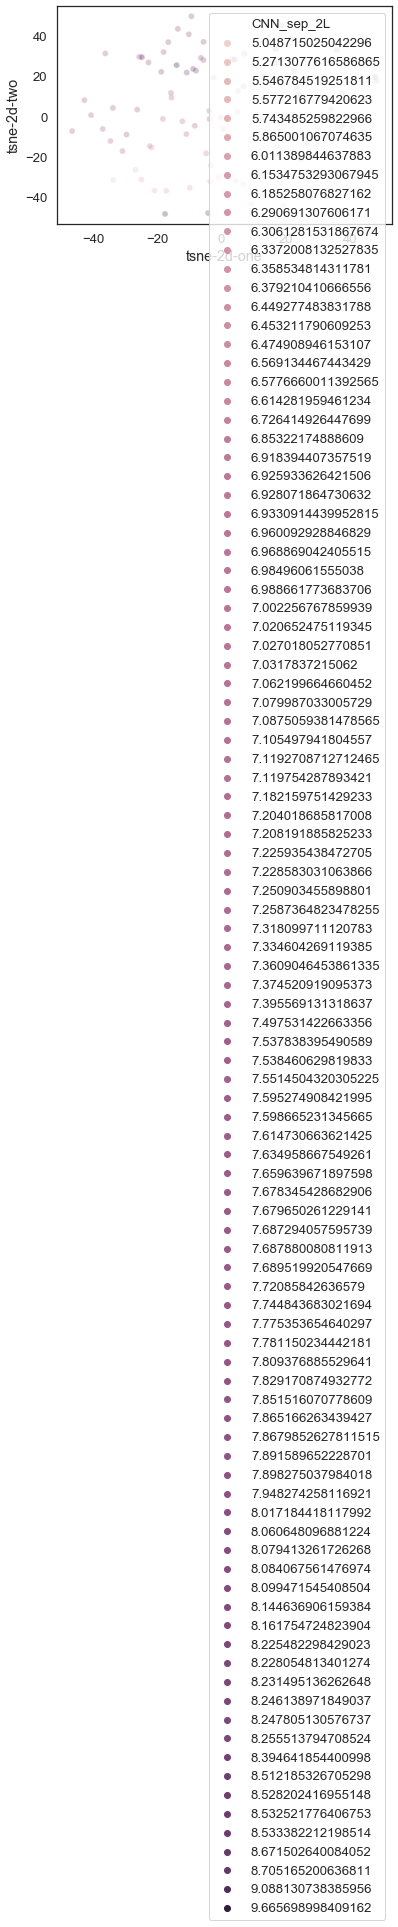

In [35]:

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="CNN_sep_2L", 
#    palette=colors,
    cmap = colors,
    data=df1,
#    legend="full",
    legend = "auto",
    alpha=0.3
)

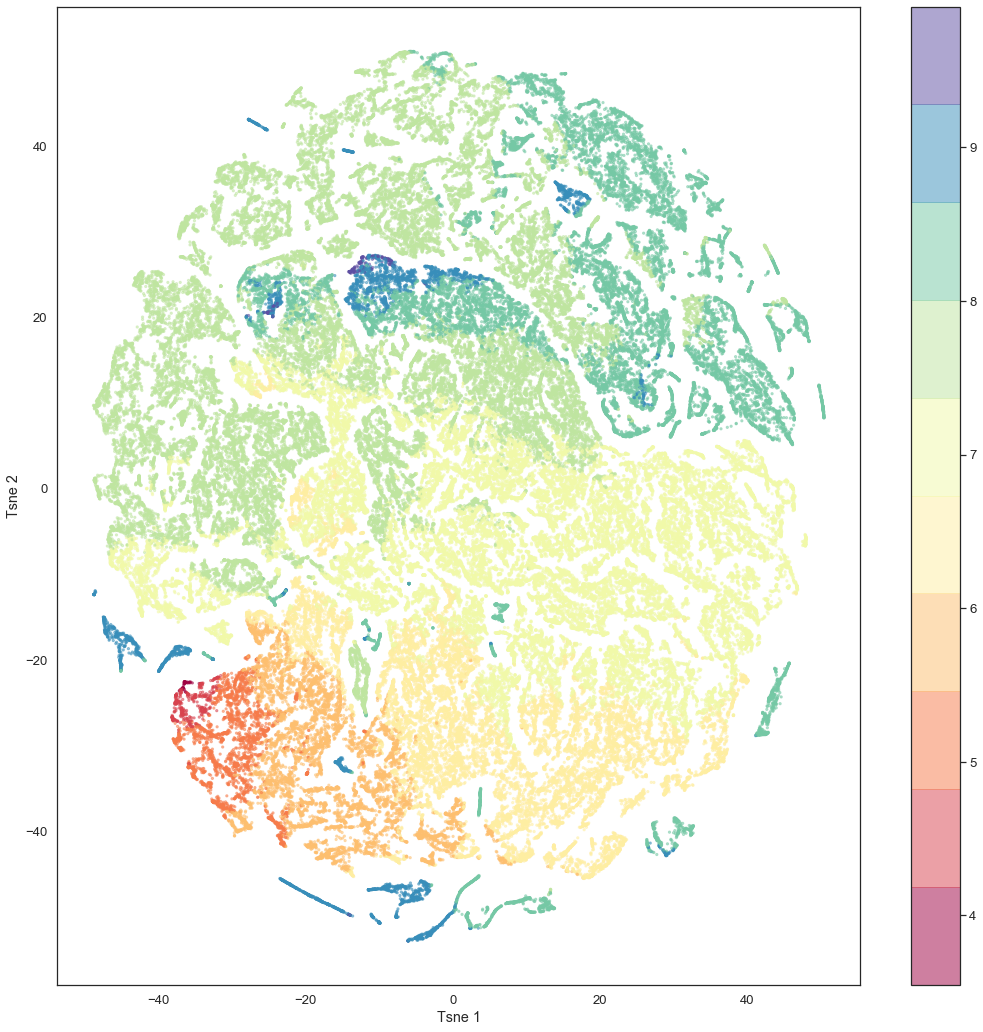

In [36]:
# Plot tsne

fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(111)
plt.scatter(df_forPCA['tsne-2d-one'], df_forPCA['tsne-2d-two'],c=df_forPCA.CNN_sep_2L, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Tsne 1')
plt.ylabel('Tsne 2')
plt.colorbar();
plt.show()




### TSNE 3 components

In [37]:
tsne_em = TSNE(n_components=3, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(df_forPCA)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 126661 samples in 1.382s...
[t-SNE] Computed neighbors for 126661 samples in 8.540s...
[t-SNE] Computed conditional probabilities for sample 1000 / 126661
[t-SNE] Computed conditional probabilities for sample 2000 / 126661
[t-SNE] Computed conditional probabilities for sample 3000 / 126661
[t-SNE] Computed conditional probabilities for sample 4000 / 126661
[t-SNE] Computed conditional probabilities for sample 5000 / 126661
[t-SNE] Computed conditional probabilities for sample 6000 / 126661
[t-SNE] Computed conditional probabilities for sample 7000 / 126661
[t-SNE] Computed conditional probabilities for sample 8000 / 126661
[t-SNE] Computed conditional probabilities for sample 9000 / 126661
[t-SNE] Computed conditional probabilities for sample 10000 / 126661
[t-SNE] Computed conditional probabilities for sample 11000 / 126661
[t-SNE] Computed conditional probabilities for sample 12000 / 126661
[t-SNE] Computed conditional probabi

[t-SNE] Computed conditional probabilities for sample 120000 / 126661
[t-SNE] Computed conditional probabilities for sample 121000 / 126661
[t-SNE] Computed conditional probabilities for sample 122000 / 126661
[t-SNE] Computed conditional probabilities for sample 123000 / 126661
[t-SNE] Computed conditional probabilities for sample 124000 / 126661
[t-SNE] Computed conditional probabilities for sample 125000 / 126661
[t-SNE] Computed conditional probabilities for sample 126000 / 126661
[t-SNE] Computed conditional probabilities for sample 126661 / 126661
[t-SNE] Mean sigma: 0.326693
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.062103
[t-SNE] KL divergence after 1000 iterations: 1.662763


In [38]:
df_forPCA['tsne-3d-one'] = tsne_em[:,0]
df_forPCA['tsne-3d-two'] = tsne_em[:,1]
df_forPCA['tsne-3d-three'] = tsne_em[:,2]

<Figure size 1296x1296 with 0 Axes>

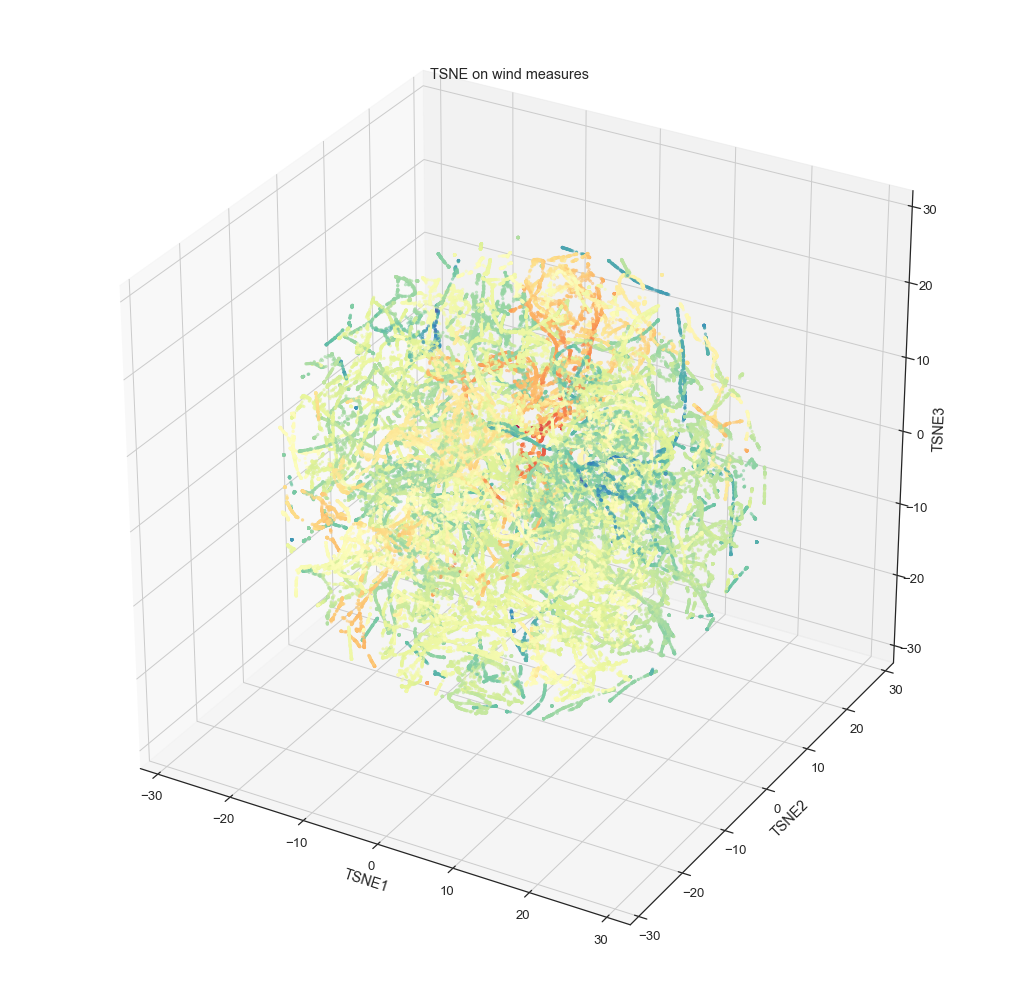

In [39]:
plt.figure(figsize=(18,18))
pca.fit(df_forPCA)

# Plot initialisation
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_forPCA['tsne-3d-one'], df_forPCA['tsne-3d-two'], df_forPCA['tsne-3d-three'], c=df_forPCA.CNN_sep_2L, s=5, 
           cmap=plt.cm.get_cmap('Spectral'), alpha=0.5)


#ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=df_forPCA.CNN_sep_2L, s= 5,
#             edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10)) 
# label the axes
ax.set_xlabel("TSNE1")
ax.set_ylabel("TSNE2")
ax.set_zlabel("TSNE3")
ax.set_title("TSNE on wind measures")
#plt.show()